In [1]:
# %matplotlib widget

import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data_io import read_iq_data
from visualisation import PDRPlotter
from receiver import ReceiverBLE, Receiver802154, Receiver
from filters import add_awgn_band_limited

In [2]:
from demodulation import TEDType
from receiver import DemodulationType, ReceiverType


# Computes the packet delivery rate (PDR) and its standard deviation over a range of AWGN SNR values
def pdr_vs_snr_analysis(
    iq_samples: np.ndarray,
    snr_range: range,
    bw_snr: float,
    fs: float,
    receiver_type: str,
    demodulation_type: str,
    ted_type: str,
    noise_realisations: int,
) -> dict:
    """
    Computes the packet delivery rate (PDR) and its standard deviation over a range of AWGN SNR values.

    A packet is considered delivered if the decoded packet passes the CRC check.
    It is considered lost if:
      - The receiver fails to detect the preamble.
      - The CRC check fails.
    """

    receiver_classes: dict[str, type[Receiver]] = {"BLE": ReceiverBLE, "IEEE802154": Receiver802154}
    try:
        receiver = receiver_classes[receiver_type](fs)
    except KeyError:
        raise ValueError(f"Invalid receiver type '{receiver_type}'. Choose from {list(receiver_classes.keys())}")

    results: dict = {}

    for snr in snr_range:
        delivered_count: int = 0
        preamble_loss_count: int = 0
        crc_failure_count: int = 0

        for _ in range(noise_realisations):
            iq_noisy = add_awgn_band_limited(iq_samples, snr_db=snr, fs=fs, bw=bw_snr)

            try:
                received_packets: list[dict] = receiver.demodulate_to_packet(
                    iq_noisy, demodulation_type=demodulation_type, ted_type=ted_type
                )
            except ValueError as e:
                if "The binary list" in str(e):
                    preamble_loss_count += 1
                    continue
                else:
                    raise

            if not received_packets:
                preamble_loss_count += 1
            elif not received_packets[0]["crc_check"]:
                crc_failure_count += 1
            else:
                delivered_count += 1

        results[snr] = {
            "pdr_ratio": delivered_count / noise_realisations,
            "preamble_loss_ratio": preamble_loss_count / noise_realisations,
            "crc_failure_ratio": crc_failure_count / noise_realisations,
        }  # preamble_loss_ratio + crc_failure_ratio + pdr_ratio = 1

    return results

# BLE example

In [3]:
bw_snrs: dict = {"BLE": 1.5e6, "IEEE802154": 3e6}
filenames: dict = {"BLE": "BLE_0dBm.dat", "IEEE802154": "802154_0dBm.dat"}  # Open BLE file

fs = 10e6  # Hz
receiver_type: ReceiverType = "BLE"
iq_samples: np.ndarray = read_iq_data(f"../../capture_nRF/data/new/{filenames[receiver_type]}")
demodulation_type: DemodulationType = "INSTANTANEOUS_FREQUENCY"
ted_type: TEDType = "MOD_MUELLER_AND_MULLER"

snr_range = range(10, 20, 1)
noise_realisations = int(1e2)

pdr: dict = pdr_vs_snr_analysis(
    iq_samples=iq_samples,
    snr_range=snr_range,
    bw_snr=bw_snrs[receiver_type],
    fs=fs,
    receiver_type=receiver_type,
    demodulation_type=demodulation_type,
    ted_type=ted_type,
    noise_realisations=noise_realisations,
)

print(pdr)

{10: {'pdr_ratio': 0.01, 'preamble_loss_ratio': 0.14, 'crc_failure_ratio': 0.85}, 11: {'pdr_ratio': 0.14, 'preamble_loss_ratio': 0.13, 'crc_failure_ratio': 0.73}, 12: {'pdr_ratio': 0.42, 'preamble_loss_ratio': 0.15, 'crc_failure_ratio': 0.43}, 13: {'pdr_ratio': 0.54, 'preamble_loss_ratio': 0.15, 'crc_failure_ratio': 0.31}, 14: {'pdr_ratio': 0.61, 'preamble_loss_ratio': 0.1, 'crc_failure_ratio': 0.29}, 15: {'pdr_ratio': 0.74, 'preamble_loss_ratio': 0.12, 'crc_failure_ratio': 0.14}, 16: {'pdr_ratio': 0.79, 'preamble_loss_ratio': 0.08, 'crc_failure_ratio': 0.13}, 17: {'pdr_ratio': 0.83, 'preamble_loss_ratio': 0.1, 'crc_failure_ratio': 0.07}, 18: {'pdr_ratio': 0.88, 'preamble_loss_ratio': 0.04, 'crc_failure_ratio': 0.08}, 19: {'pdr_ratio': 0.85, 'preamble_loss_ratio': 0.11, 'crc_failure_ratio': 0.04}}


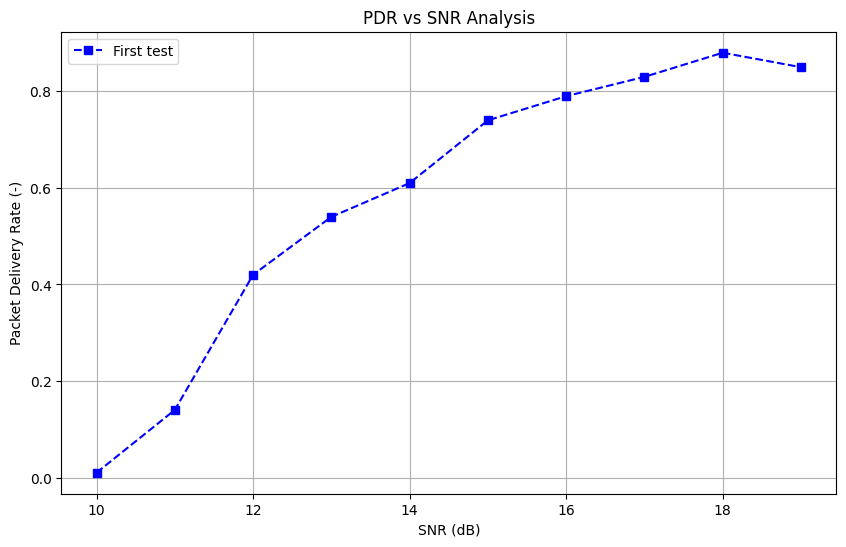

In [4]:
plotter = PDRPlotter()
plotter.add_trace(pdr, "First test", colour="blue", linestyle="--", marker="s")
plotter.plot(title="PDR vs SNR Analysis")

# IEEE 802.15.4 example 